# NYC taxis tips 

In [1]:
# Import des librairies
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot  as plt
import seaborn as sns
from datetime import datetime
from sklearn.linear_model import LinearRegression

In [2]:
# Setup de pandas pour la visualisation de dataframes
pd.set_option('display.max_columns', None)

In [3]:
#Import des datasets
train = pd.read_parquet("C:\Datasets\\taxis\\train.parquet")
test = pd.read_parquet("C:\Datasets\\taxis\\test.parquet")

In [4]:
#On garde en copie les datasets originelles en memoire au cas ou on a besoin plus tard
train_original = train.copy()
test_original = test.copy()

## Exploration des donnees

### Presentation de features

In [5]:
#Du blabla?
train.head()
test.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,PU_location_lat,PU_location_lon,DO_location_lat,DO_location_lon
row_ID,,,,,,,,,,,,,,,,,,,
0,2,2024-01-24 08:02:47,2024-01-24 08:04:45,1.0,0.36,1.0,N,1,4.4,0.0,0.5,0.0,1.0,2.5,0.0,40.740439,-73.976495,40.747746,-73.978492
1,2,2024-01-26 14:34:58,2024-01-26 14:42:51,1.0,1.78,1.0,N,1,10.7,0.0,0.5,0.0,1.0,2.5,0.0,40.791705,-73.973049,40.790011,-73.945750
2,2,2024-01-24 15:47:27,2024-01-24 15:51:48,2.0,0.43,1.0,N,2,5.8,0.0,0.5,0.0,1.0,0.0,0.0,40.791705,-73.973049,40.797962,-73.968168
3,2,2024-01-04 14:40:17,2024-01-04 14:44:21,1.0,0.61,1.0,N,1,5.8,0.0,0.5,0.0,1.0,2.5,0.0,40.783961,-73.978632,40.791705,-73.973049
4,2,2024-01-16 05:54:03,2024-01-16 05:55:59,1.0,0.71,1.0,N,2,5.1,1.0,0.5,0.0,1.0,2.5,0.0,40.748427,-73.999918,40.748427,-73.999918


### Nettoyage et preparation des données

On commence d'abord par un nettoyage rutinaire des données, visant se débarraserd es valeurs NaN. On remarque qu'il n'y a pas de données manquantes.

In [6]:
# NaNs per colonne
missing_values = train.isnull().sum()

# Colonnes avec des NaN
missing_columns = missing_values[missing_values > 0]
print(missing_columns)

Series([], dtype: int64)


Avant de procéder à une étude univariée et bivariée, nous devons transformer certaines variables en formats numériques. Pour l'instant, nous effectuerons des transformations de base pour procéder à une étude, et dans une section ultérieure, nous effectuerons des transformations plus avancées des variables.

In [7]:
# Nous créons une unique variable à partir des variables avec format datetype
train['trip_duration'] = (train['tpep_dropoff_datetime'] - train['tpep_pickup_datetime']).dt.total_seconds() / 60 # Trip duration in minutes
test['trip_duration'] = (test['tpep_dropoff_datetime'] - test['tpep_pickup_datetime']).dt.total_seconds() / 60 

# Encoding des variables categorielles: d'abord on teste des encodings basiques
# Store_and_fwd_flag: dummy
train['store_and_fwd_flag'] = train['store_and_fwd_flag'].map({'Y': 1, 'N': 0})
test['store_and_fwd_flag'] = test['store_and_fwd_flag'].map({'Y': 1, 'N': 0})
# VendorID, RateCodeID et Payment_type: one-hot
categorical_features = ['VendorID', 'RateCodeID', 'Payment_type']

train = pd.get_dummies(train, columns=['VendorID', 'RatecodeID', 'payment_type'], dtype=int) # On ajoute dtype int à la fin pour assurer un format non-booléen afin de garantir la compatibilité avec scikit learn
test = pd.get_dummies(test, columns=['VendorID', 'RatecodeID', 'payment_type'], dtype=int)

train, test = train.align(test, join='left', axis=1, fill_value=0) # Certaines catégories n'apparaissent que dans le train set, il faut donc adapter l'encoding dans le test set. 
test = test.drop(columns=['tip_amount'])

### Étude univariée et bivariée

##### Univariée
Nous examinons ici les distributions de certaines covariables. Nous nous intéressons en particulier à la cohérence des valeurs prises par les covariables ainsi qu'aux valeurs extrêmes.

In [8]:
#hacer grafica de duracion de trayectos y eliminar el trayecto de duración 0. Lo mimso con passenger count (hay algunos viajes con 0 pasajeros). En el rapport explicar que en circusntancias normales, no tendriamos estos trayectos en cuenta, pero puesot que necesitamos hacer las predicciones reemplazamos por la media (o la mediana)

##### Trip duration
We first look for extreme values. We can safely assume that any trip that is over 5 hours (300 min) long is an error. In the same way, the duration for a trip can't be 0.

   

In [9]:
len(train[train['trip_duration']>300]['trip_duration']) # 63 such trips in the training set
len(test[test['trip_duration']>300]['trip_duration']) #!! 1689 trips in the test set

#This suggests that distributions might not be similar across train and test sets. Let's now check trips of duration 0:

len(train[train['trip_duration']==0]['trip_duration']) #1
len(test[test['trip_duration']==0]['trip_duration']) #33

# We have less cases. Let's investigate if these are cancelled trips or just errors:

33

In [10]:
test[test['trip_duration']==0].head()
#We notice how the trip distance is nonzero, as well as the fare_amount, so these are errors and not cancelled trips. 

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,store_and_fwd_flag,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,PU_location_lat,PU_location_lon,DO_location_lat,DO_location_lon,trip_duration,VendorID_1,VendorID_2,RatecodeID_1.0,RatecodeID_2.0,RatecodeID_3.0,RatecodeID_4.0,RatecodeID_5.0,RatecodeID_99.0,payment_type_1,payment_type_2,payment_type_3,payment_type_4
row_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
125498,2024-01-08 15:16:40,2024-01-08 15:16:40,0.0,4.20,0,3.0,0.0,0.5,0.0,1.0,0.0,0.0,40.745379,-73.948892,40.745379,-73.948892,0.0,1,0,1,0,0,0,0,0,0,1,0,0
189900,2024-01-09 17:40:00,2024-01-09 17:40:00,1.0,18.60,0,70.0,0.0,0.5,0.0,1.0,2.5,0.0,40.646985,-73.786530,40.723888,-74.001538,0.0,0,1,0,1,0,0,0,0,1,0,0,0
258501,2024-01-30 07:32:57,2024-01-30 07:32:57,1.0,0.70,0,5.1,2.5,0.5,0.0,1.0,2.5,0.0,40.791705,-73.973049,40.791705,-73.973049,0.0,1,0,1,0,0,0,0,0,1,0,0,0
482498,2024-01-23 00:00:00,2024-01-23 00:00:00,5.0,3.64,0,102.4,2.5,0.5,0.0,1.0,2.5,0.0,40.791705,-73.973049,40.791705,-73.973049,0.0,0,1,1,0,0,0,0,0,1,0,0,0
504436,2024-01-16 01:00:18,2024-01-16 01:00:18,1.0,0.70,0,5.8,3.5,0.5,0.0,1.0,2.5,0.0,40.756688,-73.972356,40.756688,-73.972356,0.0,1,0,1,0,0,0,0,0,0,1,0,0


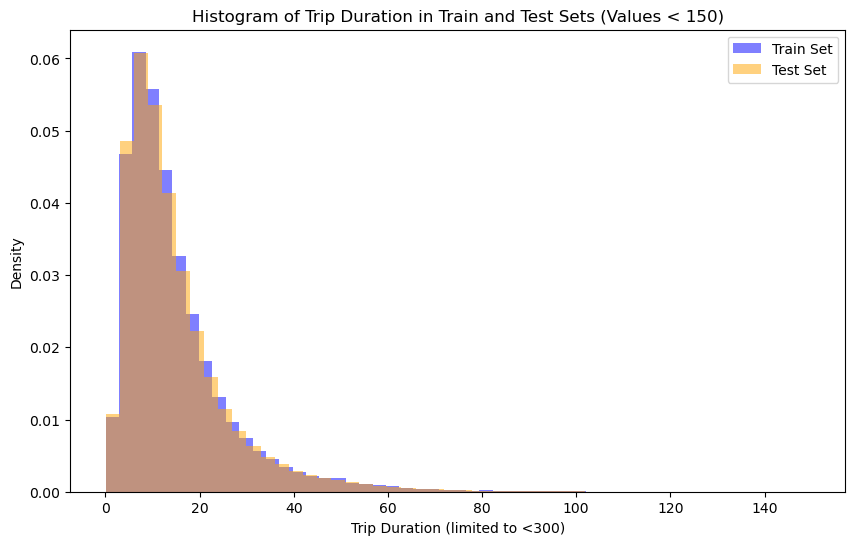

In [11]:
# Filter values to include only those less than 150 (provides clearer visualization than with <300)
train_filtered = train[(train['trip_duration'] > 0) & (train['trip_duration'] < 150)]
test_filtered = test[(test['trip_duration'] > 0) & (test['trip_duration'] < 150)]

# Plot the histograms
plt.figure(figsize=(10, 6))

# Train set histogram
plt.hist(train_filtered['trip_duration'], bins=50, color='blue', alpha=0.5, density=True, label='Train Set')

# Test set histogram
plt.hist(test_filtered['trip_duration'], bins=50, color='orange', alpha=0.5, density=True, label='Test Set')

# Add labels and title
plt.xlabel('Trip Duration (limited to <300)')
plt.ylabel('Density')
plt.title('Histogram of Trip Duration in Train and Test Sets (Values < 150)')
plt.legend()
plt.show()


Distributions are very similar. We now need a way of handling the measurement errors. A very natural idea is to use the trip_distance variable. I expect this variable to be highly correlated with trip_duration. Let's verify:

In [12]:
train[['trip_distance', 'trip_duration']].corr().iloc[0, 1] # 0.2614, which is super low
test[['trip_distance', 'trip_duration']].corr().iloc[0, 1] # 0.2656, similar

#Of course, this is the general case with the outliers. Let's see how it should be:

train[(train['trip_duration'] > 0) & (train['trip_duration'] < 300)][['trip_distance', 'trip_duration']].corr().iloc[0, 1] #0.7934
test[(test['trip_duration'] > 0) & (test['trip_duration'] < 300)][['trip_distance', 'trip_duration']].corr().iloc[0, 1] #0.7888



0.7888151400475526

We find much more reasonable values. 

In [13]:
df1 = train[(train['trip_duration'] > 0) & (train['trip_duration'] < 300)].drop(columns=['tip_amount'])
df2 = test[(test['trip_duration'] > 0) & (test['trip_duration'] < 300)]

combined_df = pd.concat([df1, df2], axis=0).reset_index(drop=True)

X = combined_df[['trip_distance']]  # Predictor needs to be a 2D array
y = combined_df['trip_duration']    # Response variable

# Initialize and fit the linear regression model
model = LinearRegression()
model.fit(X, y)
slope = model.coef_[0]

In [14]:
# We now replace the nonsensical values with a simple estimation of them
# Replace nonsensical values in 'train' DataFrame
train.loc[(train['trip_duration'] == 0) | (train['trip_duration'] > 300), 'trip_duration'] = train.loc[(train['trip_duration'] == 0) | (train['trip_duration'] > 300), 'trip_distance'] * slope


# Replace nonsensical values in 'test' DataFrame
test.loc[(test['trip_duration'] == 0) | (test['trip_duration'] > 300), 'trip_duration'] = test.loc[(test['trip_duration'] == 0) | (test['trip_duration'] > 300), 'trip_distance'] * slope



#### Bivariée

In [15]:
numerical_vars = train.select_dtypes(include=['float64', 'int64']).columns

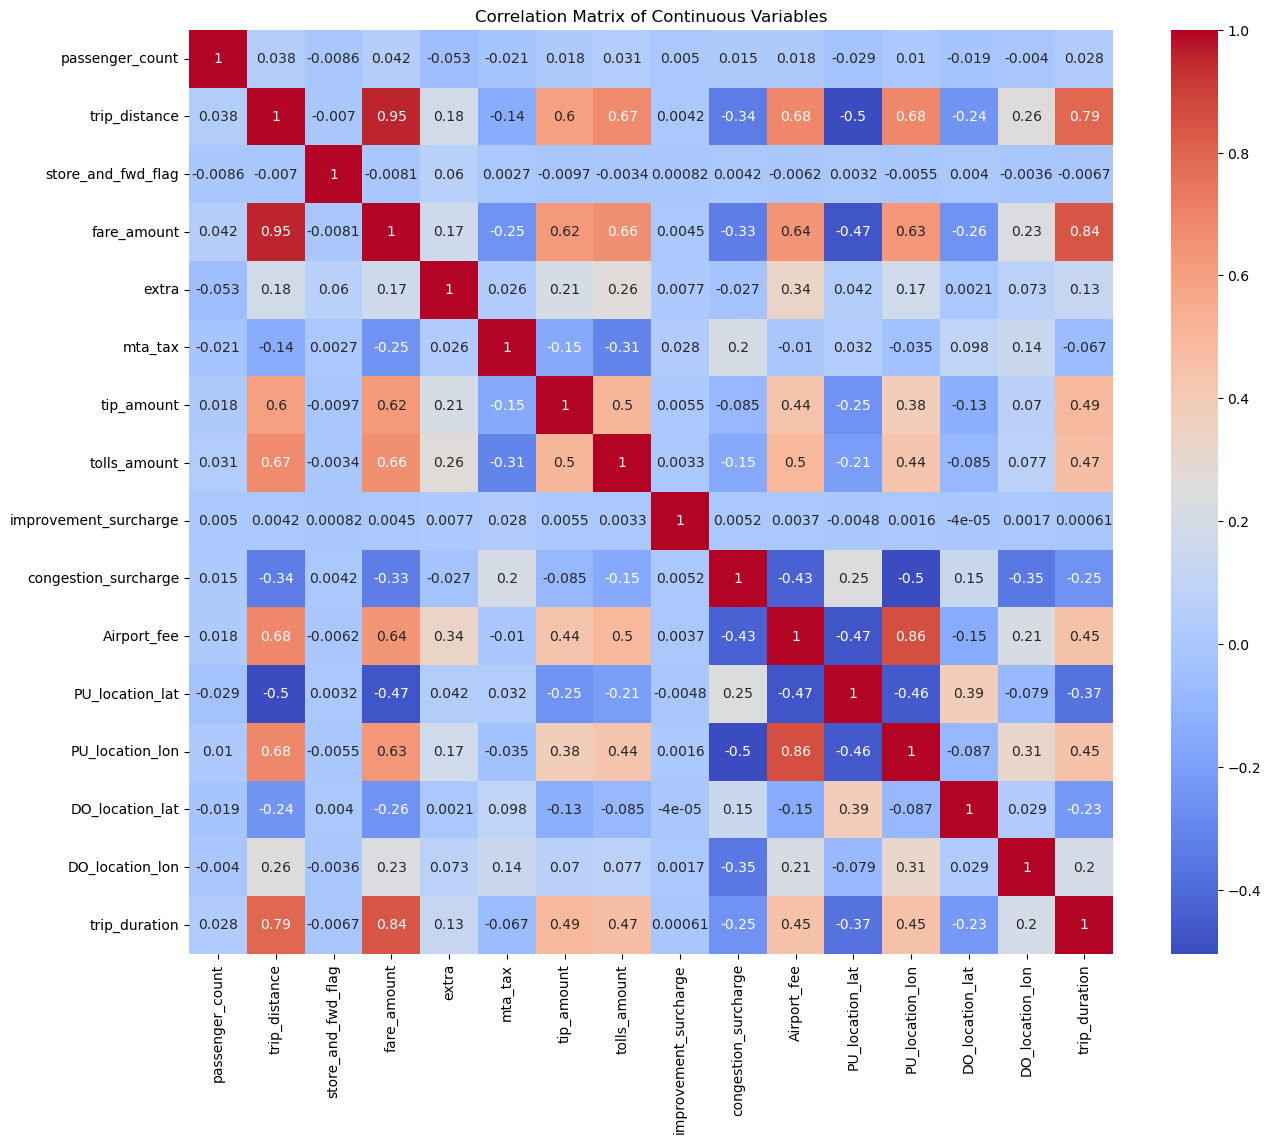

In [16]:
# Plotting the correlation matrix
plt.figure(figsize=(15, 12))
#sns.heatmap(train[numerical_vars].corr(), annot=True, cmap='coolwarm', square=True)
sns.heatmap(train[train['trip_duration'] < 300][numerical_vars].corr(), annot=True, cmap='coolwarm', square=True)

plt.title('Correlation Matrix of Continuous Variables')
plt.show()

### Variables d'emplacement

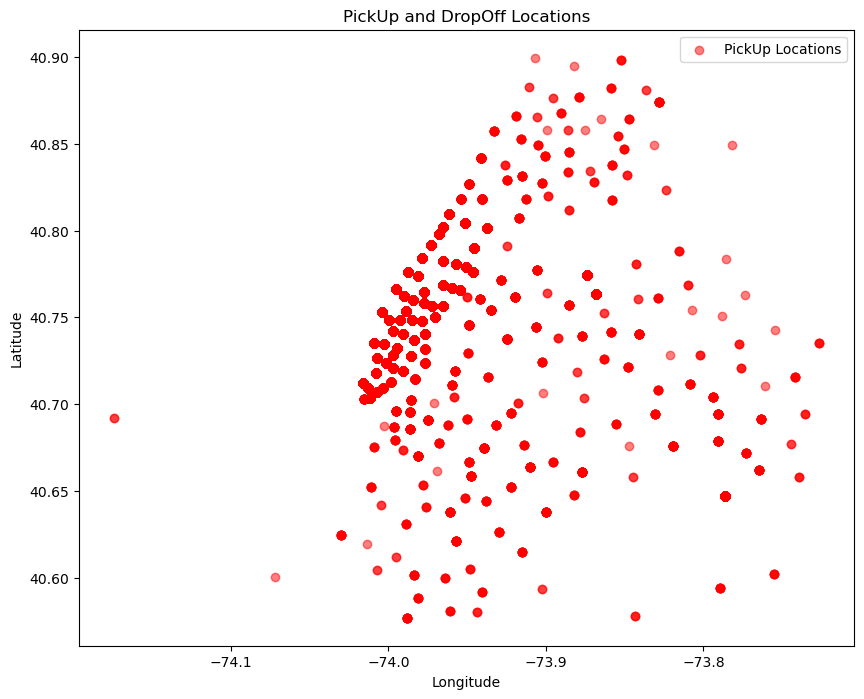

In [17]:
import matplotlib.pyplot as plt

# Extract coordinates for pickup and dropoff locations
PU_lat = train['PU_location_lat']
PU_lon = train['PU_location_lon']
DO_lat = train['DO_location_lat']
DO_lon = train['DO_location_lon']

# Create the plot
plt.figure(figsize=(10, 8))

# Plot pickup locations in red
plt.scatter(PU_lon, PU_lat, color='red', label='PickUp Locations', alpha=0.5)

#Plot dropoff locations in green
#plt.scatter(DO_lon, DO_lat, color='green', label='DropOff Locations', alpha=0.5)

# Draw a dashed line between each pickup and dropoff point for the same trip
'''
for i in range(len(PU_lat)):
    plt.plot([PU_lon[i], DO_lon[i]], [PU_lat[i], DO_lat[i]], 'k--', alpha=0.3)
'''
# Add labels and legend
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('PickUp and DropOff Locations')
plt.legend()
plt.show()


## Feature engineering

On se dispose dans cette section a creer de covariables supplementaires potentiellement representatives et informatives

### Features derivées des pickup_datetime et dropoff_datetime

In [18]:
train['trip_speed'] = train['trip_distance'] / train['trip_duration']
test['trip_speed'] = test['trip_distance'] / test['trip_duration']

train['hour'] = train['tpep_pickup_datetime'].dt.hour
test['hour'] = test['tpep_pickup_datetime'].dt.hour


### Features derivées de variables d'emplacement

In [19]:
# Create a combined pickup location column
'''
train['PU_location'] = train[['PU_location_lat', 'PU_location_lon']].apply(tuple, axis=1)
# Factorize the unique pickup locations
train['PU_location_level'] = pd.factorize(train['PU_location'])[0]

# Create a combined dropoff location column
train['DO_location'] = train[['DO_location_lat', 'DO_location_lon']].apply(tuple, axis=1)
# Factorize the unique dropoff locations
train['DO_location_level'] = pd.factorize(train['DO_location'])[0]

# Drop the temporary combined columns if not needed
train = train.drop(['PU_location', 'DO_location'], axis=1)
'''


"\ntrain['PU_location'] = train[['PU_location_lat', 'PU_location_lon']].apply(tuple, axis=1)\n# Factorize the unique pickup locations\ntrain['PU_location_level'] = pd.factorize(train['PU_location'])[0]\n\n# Create a combined dropoff location column\ntrain['DO_location'] = train[['DO_location_lat', 'DO_location_lon']].apply(tuple, axis=1)\n# Factorize the unique dropoff locations\ntrain['DO_location_level'] = pd.factorize(train['DO_location'])[0]\n\n# Drop the temporary combined columns if not needed\ntrain = train.drop(['PU_location', 'DO_location'], axis=1)\n"

## Model fitting

In [20]:
## Model fitting
#train = train.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'PU_location_lat', 'PU_location_lon', 'DO_location_lat', 'DO_location_lon'])
#test = test.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'PU_location_lat', 'PU_location_lon', 'DO_location_lat', 'DO_location_lon'])

train = train.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime',])
test = test.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime',])

X_train = train.drop(columns=['tip_amount'])
y_train = train['tip_amount']

X_test = test

In [21]:
#Linear regression
'''
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
'''

'\nfrom sklearn.linear_model import LinearRegression\n\nmodel = LinearRegression()\n\nmodel.fit(X_train, y_train)\ny_pred = model.predict(X_test)\n'

In [22]:
#GAM
'''
import statsmodels.api as sm
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit a GLM with Gaussian family (similar to linear regression)
glm_model = sm.GLM(y_train, X_train, family=sm.families.Gaussian())
glm_results = glm_model.fit()

# Predict on the test set
y_pred = glm_results.predict(X_test)
'''

'\nimport statsmodels.api as sm\nX_train = sm.add_constant(X_train)\nX_test = sm.add_constant(X_test)\n\n# Fit a GLM with Gaussian family (similar to linear regression)\nglm_model = sm.GLM(y_train, X_train, family=sm.families.Gaussian())\nglm_results = glm_model.fit()\n\n# Predict on the test set\ny_pred = glm_results.predict(X_test)\n'

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Initialize the model
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
random_forest.fit(X_train, y_train)

# Predict on the test data
y_pred = random_forest.predict(X_test)

In [25]:
# Get today's date in the format YYYYMMDD
today_date = datetime.now().strftime("%Y_%m_%d")

# Create the submission DataFrame
submission = pd.DataFrame({
    'row_ID': test.index,  # Use 'row_ID' column or index from the test set
    'tip_amount': y_pred
})

# Save the submission in Parquet format with today's date in the filename
filename = f'kaggle_submission_{today_date}.parquet'
submission.to_parquet(filename, index=False)

print(f"Predictions saved to '{filename}'")


Predictions saved to 'kaggle_submission_2024_11_09.parquet'
